![](../img/330-banner.png)

# Tutorial 8

UBC 2024-26

## Outline

During this tutorial, you will 

All questions can be discussed with your classmates and the TAs - this is not a graded exercise!

### Imports

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    TimeSeriesSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

plt.rcParams["font.size"] = 12
from datetime import datetime

DATA_DIR = os.path.join(os.path.abspath(".."), "data/")

## Time series analysis on a more complicated dataset 

For this exercise, we will use the [rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) dataset. Our goal is to predict whether or not it will rain tomorrow based on today's measurements.

In [2]:
rain_df = pd.read_csv(DATA_DIR + "weatherAUS.csv")
rain_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
rain_df.shape

(145460, 23)

**Questions of interest**

- Can we **forecast** into the future? Can we predict whether it's going to rain tomorrow?
    - The target variable is `RainTomorrow`. The target is categorical and not continuous in this case. 
- Can the date/time features help us predict the target value?


### Exploratory data analysis

We are doing some basic EDA to help you familiarize with the dataset - check our results below.

In [4]:
rain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [5]:
rain_df.describe(include="all")

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,145460,145460,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135134,135197.000000,134894,...,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000,142199,142193
unique,3436,49,NaN,NaN,NaN,NaN,NaN,16,NaN,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,2013-11-12,Canberra,NaN,NaN,NaN,NaN,NaN,W,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No
freq,49,3436,NaN,NaN,NaN,NaN,NaN,9915,NaN,11758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110319,110316
mean,NaN,NaN,12.194034,23.221348,2.360918,5.468232,7.611178,NaN,40.035230,NaN,...,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339,NaN,NaN
std,NaN,NaN,6.398495,7.119049,8.478060,4.193704,3.785483,NaN,13.607062,NaN,...,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665,NaN,NaN
min,NaN,NaN,-8.500000,-4.800000,0.000000,0.000000,0.000000,NaN,6.000000,NaN,...,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000,NaN,NaN
25%,NaN,NaN,7.600000,17.900000,0.000000,2.600000,4.800000,NaN,31.000000,NaN,...,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000,NaN,NaN
50%,NaN,NaN,12.000000,22.600000,0.000000,4.800000,8.400000,NaN,39.000000,NaN,...,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000,NaN,NaN
75%,NaN,NaN,16.900000,28.200000,0.800000,7.400000,10.600000,NaN,48.000000,NaN,...,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000,NaN,NaN


- A number of missing values. 
- Some target values are also missing. Let's drop these rows. 

In [6]:
rain_df = rain_df[rain_df["RainTomorrow"].notna()]
rain_df.shape

(142193, 23)

### Parsing datetimes 

- In general, datetimes are a huge pain! 
    - Think of all the formats: MM-DD-YY, DD-MM-YY, YY-MM-DD, MM/DD/YY, DD/MM/YY, DD/MM/YYYY, 20:45, 8:45am, 8:45 PM, 8:45a, 08:00, 8:10:20, .......
  - Time zones.
  - Daylight savings...
- Thankfully, pandas does a pretty good job here.

In [7]:
dates_rain = pd.to_datetime(rain_df["Date"])
dates_rain

0        2008-12-01
1        2008-12-02
2        2008-12-03
3        2008-12-04
4        2008-12-05
            ...    
145454   2017-06-20
145455   2017-06-21
145456   2017-06-22
145457   2017-06-23
145458   2017-06-24
Name: Date, Length: 142193, dtype: datetime64[ns]

They are all the same format, so we can also compare dates:

In [8]:
dates_rain[1] - dates_rain[0] 

Timedelta('1 days 00:00:00')

In [9]:
dates_rain[1] > dates_rain[0]

True

In [10]:
(dates_rain[1] - dates_rain[0]).total_seconds()

86400.0

We can also easily extract information from the date columns. 

In [11]:
dates_rain[1]

Timestamp('2008-12-02 00:00:00')

In [12]:
dates_rain[1].month_name()

'December'

In [13]:
dates_rain[1].day_name()

'Tuesday'

In [14]:
dates_rain[1].is_year_end

False

In [15]:
dates_rain[1].is_leap_year

True

Above, pandas identified the date column automatically. You can also tell pandas to parse the dates when reading in the CSV:

In [16]:
rain_df = pd.read_csv(DATA_DIR + "weatherAUS.csv", parse_dates=["Date"])
rain_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [17]:
# Since we re-read the csv file, let's remove the missing targets again
rain_df = rain_df[rain_df["RainTomorrow"].notna()]
rain_df.shape

(142193, 23)

### <font color='red'>Question 1</font>
- How many time series are present in this dataset? 
- Are the measurements equally spaced? Use the function provided below to help you answer this question.


In [18]:
def plot_time_spacing_distribution(df, region="Adelaide"):
    """
    Plots the distribution of time spacing for a given region.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with columns 'Location' and 'Date'.
        region (str): The region (e.g., location) to analyze.
    """
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Filter data for the given region
    region_data = df[df['Location'] == region]
    
    if region_data.empty:
        print(f"No data available for region: {region}")
        return
    
    # Calculate time differences
    time_diffs = region_data['Date'].sort_values().diff().dropna()
    
    # Count the frequency of each time difference
    value_counts = time_diffs.value_counts().sort_index()
    
    # Display value counts
    print(f"Time spacing counts for {region}:\n{value_counts}\n")
    
    # Plot the bar chart
    plt.bar(value_counts.index.astype(str), value_counts.values, color='skyblue', edgecolor='black')
    plt.title(f"Time Difference Distribution for {region}")
    plt.xlabel("Time Difference (days)")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Time spacing counts for Albury:
Date
1 days     2987
2 days       16
4 days        3
5 days        1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



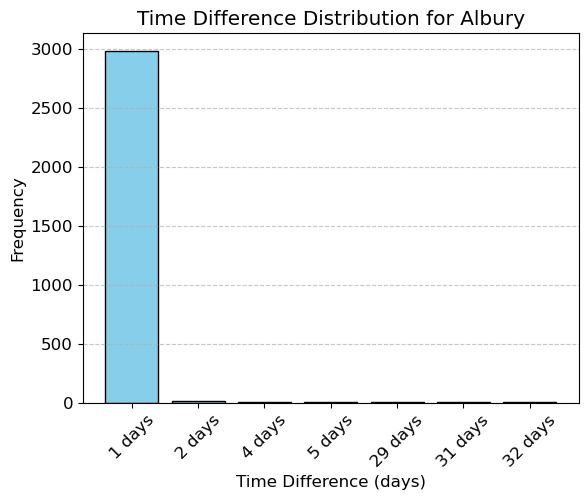

Time spacing counts for BadgerysCreek:
Date
1 days     2873
2 days       40
3 days        8
4 days        1
6 days        1
18 days       1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



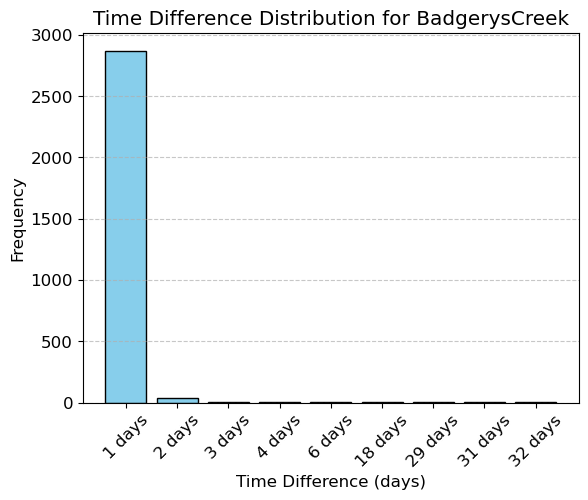

Time spacing counts for Cobar:
Date
1 days     2976
2 days        2
3 days        2
4 days        3
7 days        1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



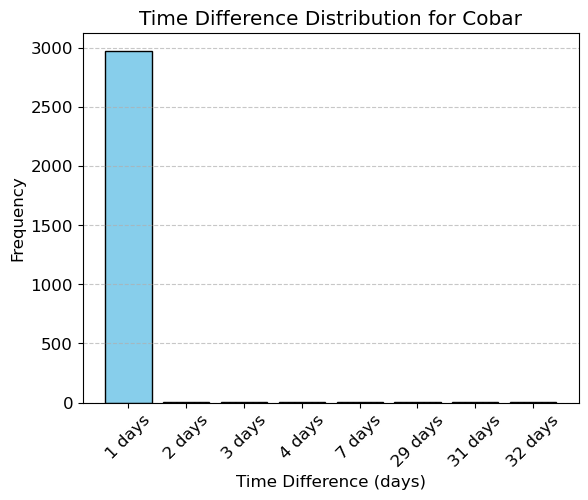

Time spacing counts for CoffsHarbour:
Date
1 days     2936
2 days        8
4 days        1
5 days        1
6 days        1
8 days        1
29 days       1
30 days       1
31 days       1
32 days       1
Name: count, dtype: int64



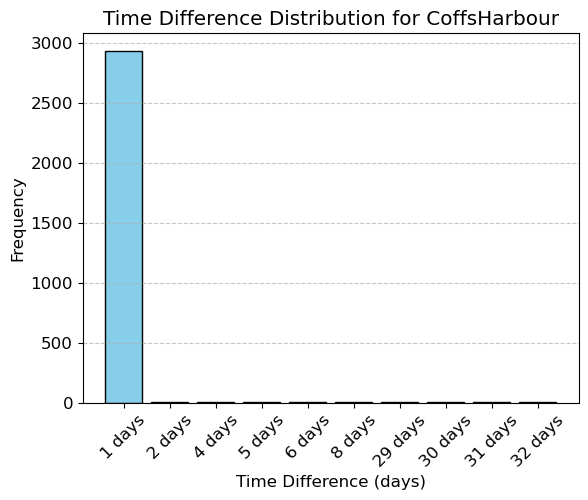

Time spacing counts for Moree:
Date
1 days     2787
2 days       11
3 days       24
4 days       24
6 days        1
7 days        2
8 days        1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



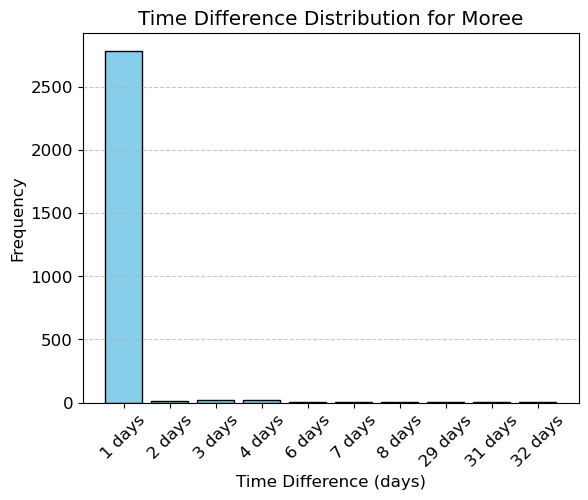

Time spacing counts for Newcastle:
Date
1 days     2925
2 days       13
3 days        2
5 days        1
6 days        4
7 days        2
8 days        2
9 days        1
10 days       1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



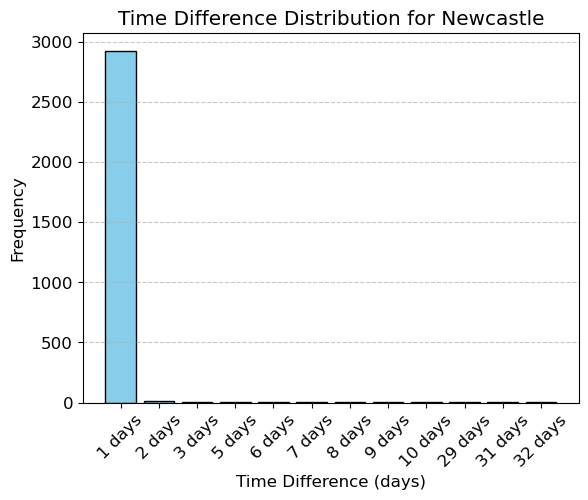

Time spacing counts for NorahHead:
Date
1 days     2884
2 days       29
3 days        6
4 days        1
5 days        2
6 days        1
12 days       1
13 days       1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



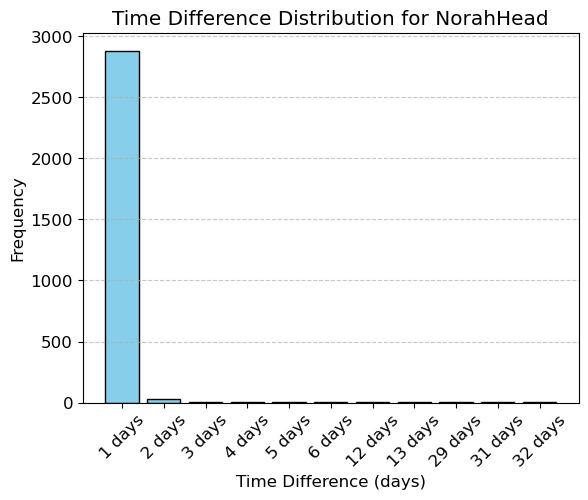

Time spacing counts for NorfolkIsland:
Date
1 days     2940
2 days        4
3 days       14
4 days        1
11 days       1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



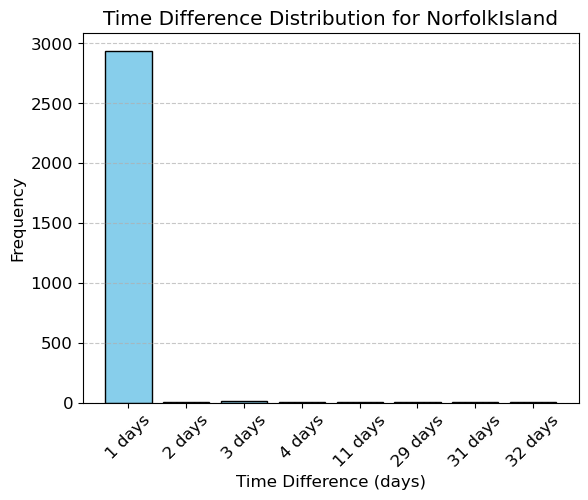

Time spacing counts for Penrith:
Date
1 days     2907
2 days       41
3 days        7
4 days        2
5 days        1
6 days        1
7 days        1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



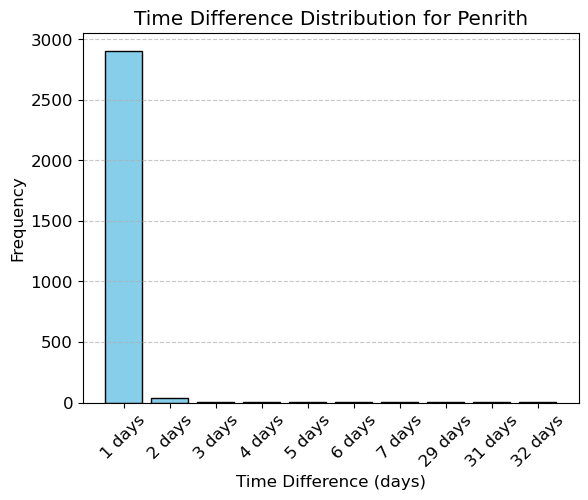

Time spacing counts for Richmond:
Date
1 days     2902
2 days       37
3 days        6
5 days        1
6 days        1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



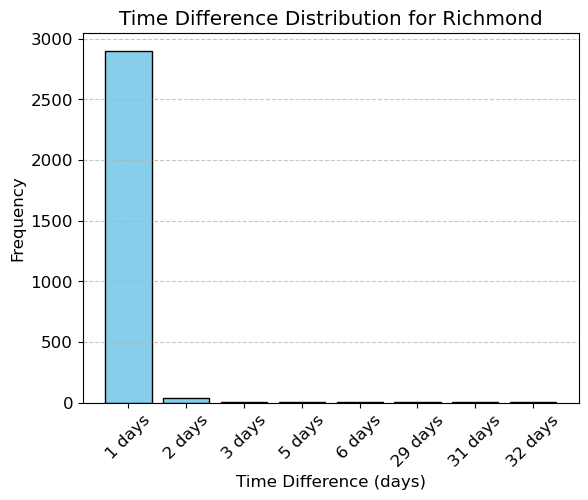

Time spacing counts for Sydney:
Date
1 days     3327
2 days        5
3 days        1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



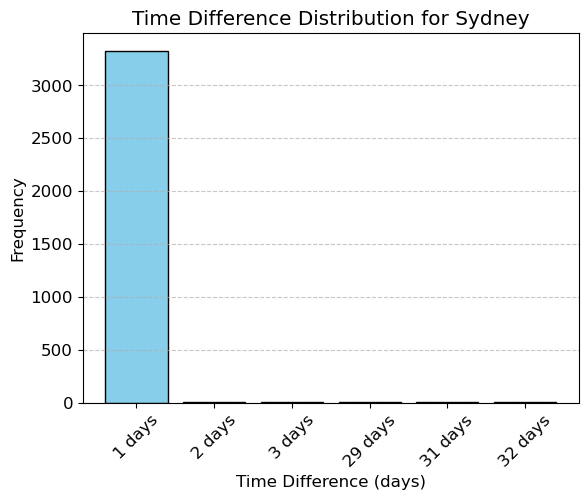

Time spacing counts for SydneyAirport:
Date
1 days     2997
2 days        4
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



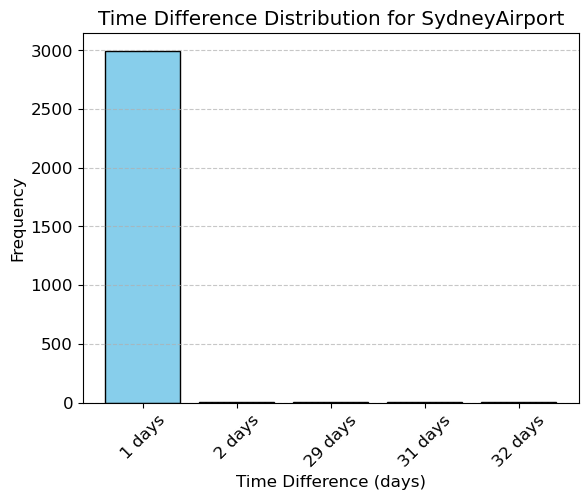

Time spacing counts for WaggaWagga:
Date
1 days     2954
2 days        5
3 days       12
5 days        1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



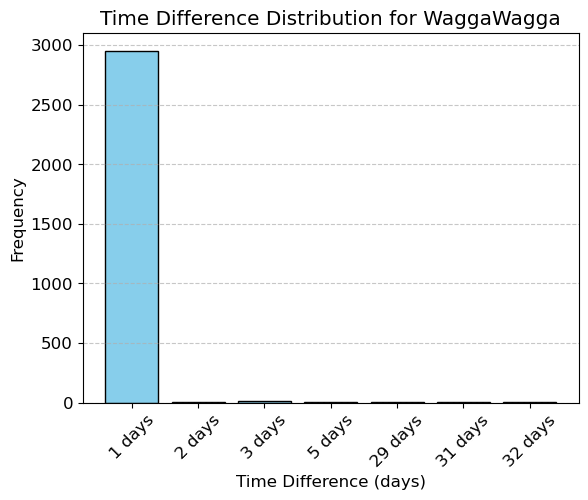

Time spacing counts for Williamtown:
Date
1 days     2373
2 days       25
3 days       68
4 days       71
5 days        4
6 days        4
7 days        1
8 days        1
14 days       1
19 days       1
31 days       2
32 days       1
Name: count, dtype: int64



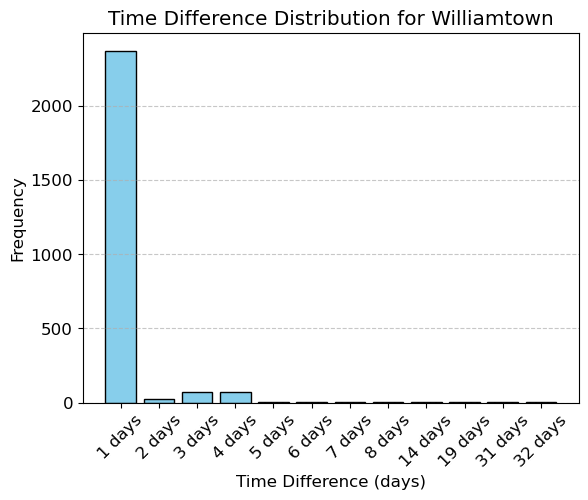

Time spacing counts for Wollongong:
Date
1 days     2940
2 days       30
3 days        8
10 days       1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



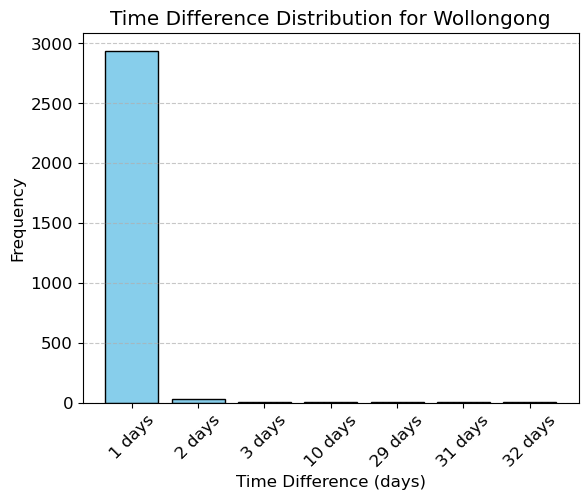

Time spacing counts for Canberra:
Date
1 days     3398
2 days       14
3 days        2
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



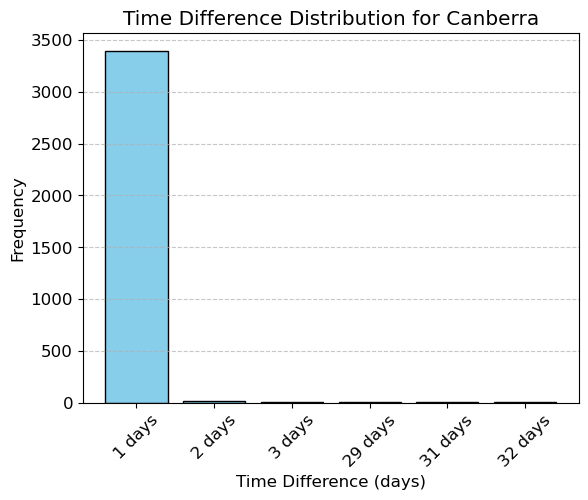

Time spacing counts for Tuggeranong:
Date
1 days     2955
2 days       36
3 days        3
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



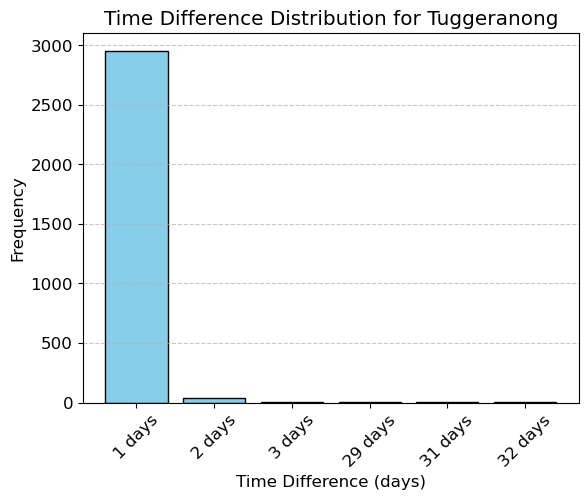

Time spacing counts for MountGinini:
Date
1 days     2812
2 days       57
3 days       28
4 days        4
5 days        2
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



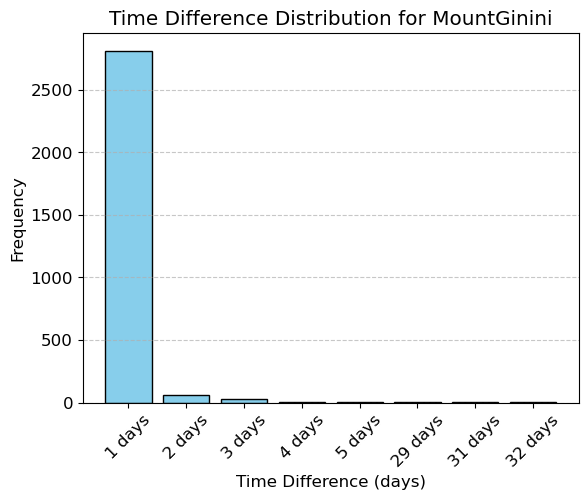

Time spacing counts for Ballarat:
Date
1 days     3013
2 days       10
3 days        1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



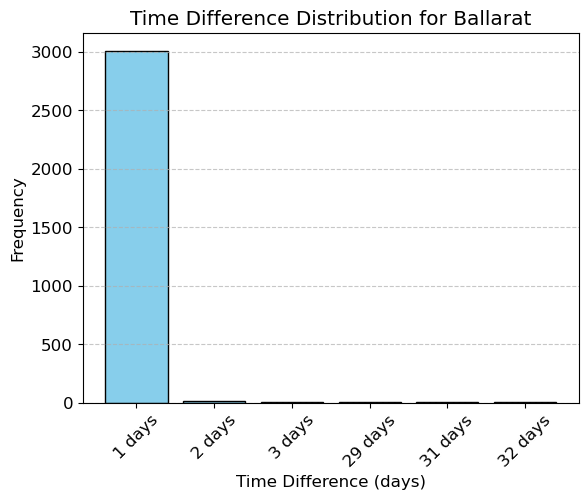

Time spacing counts for Bendigo:
Date
1 days     3026
2 days        2
3 days        2
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



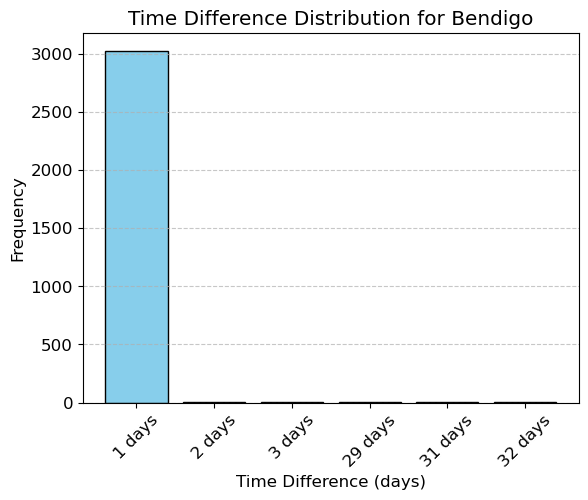

Time spacing counts for Sale:
Date
1 days     2988
2 days        7
3 days        1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



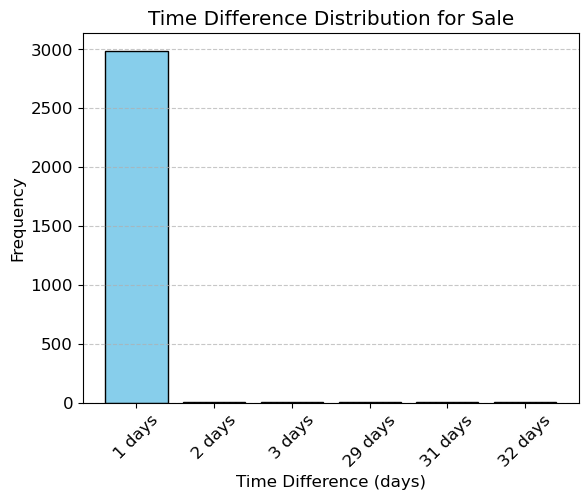

Time spacing counts for MelbourneAirport:
Date
1 days     3005
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



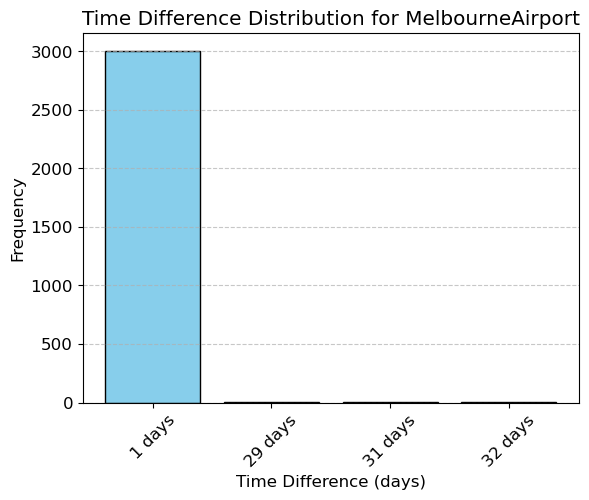

Time spacing counts for Melbourne:
Date
1 days      2294
2 days        17
3 days       102
4 days        13
5 days         3
7 days         1
29 days        1
31 days        1
32 days        1
481 days       1
Name: count, dtype: int64



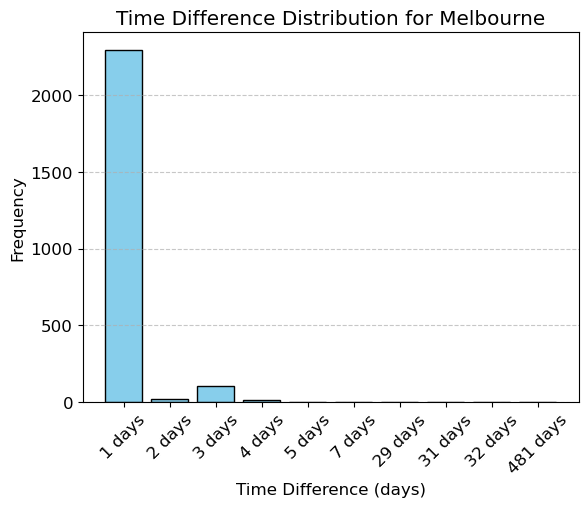

Time spacing counts for Mildura:
Date
1 days     3001
2 days        2
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



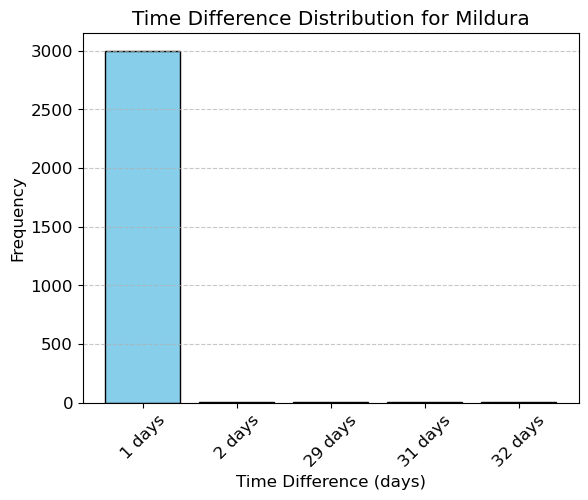

Time spacing counts for Nhil:
Date
1 days    1564
2 days       3
7 days       1
Name: count, dtype: int64



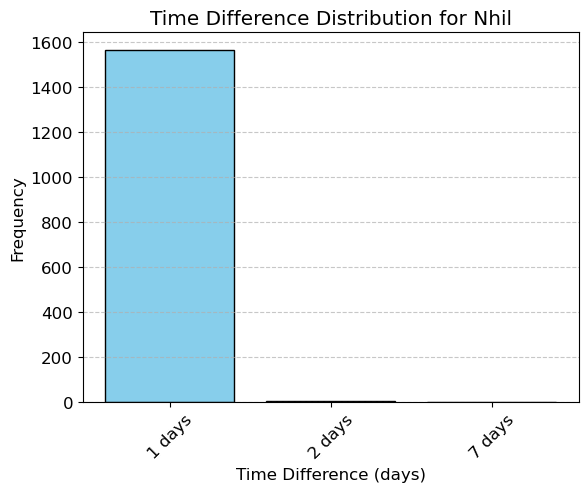

Time spacing counts for Portland:
Date
1 days     2980
2 days       11
3 days        1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



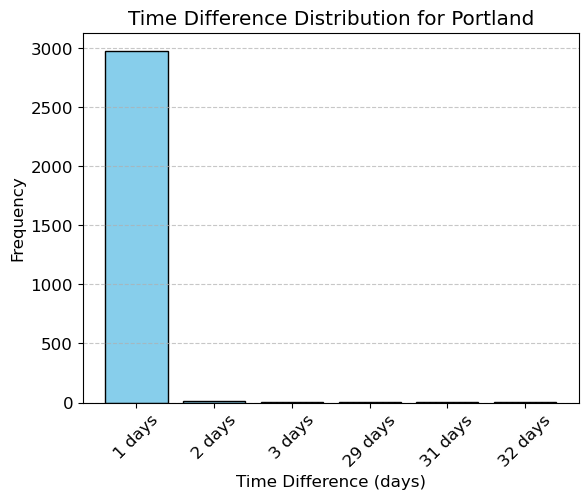

Time spacing counts for Watsonia:
Date
1 days     2986
2 days        8
3 days        1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



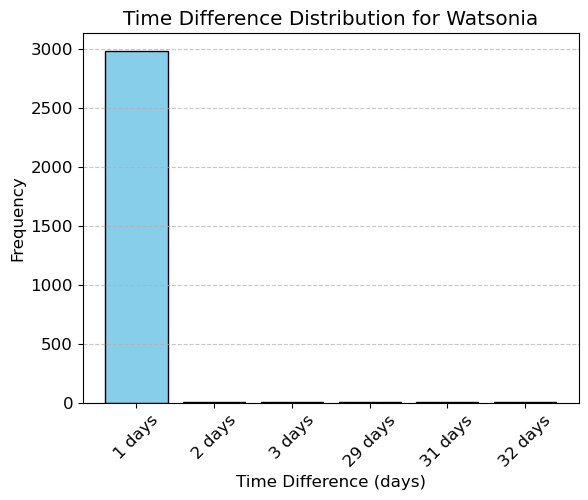

Time spacing counts for Dartmoor:
Date
1 days     2936
2 days        3
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



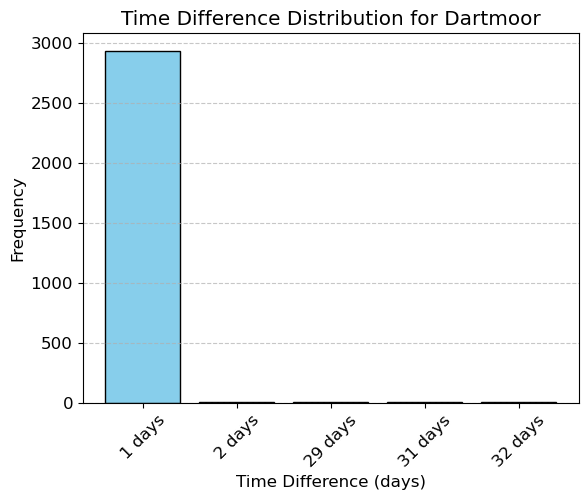

Time spacing counts for Brisbane:
Date
1 days     3128
2 days       26
3 days        3
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



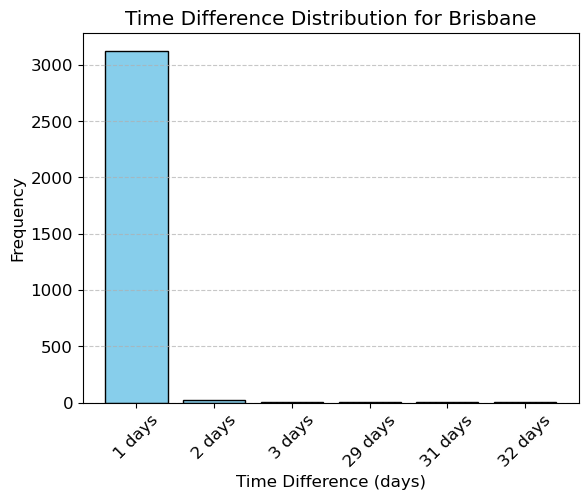

Time spacing counts for Cairns:
Date
1 days     2960
2 days       10
3 days        5
4 days        6
5 days        1
6 days        2
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



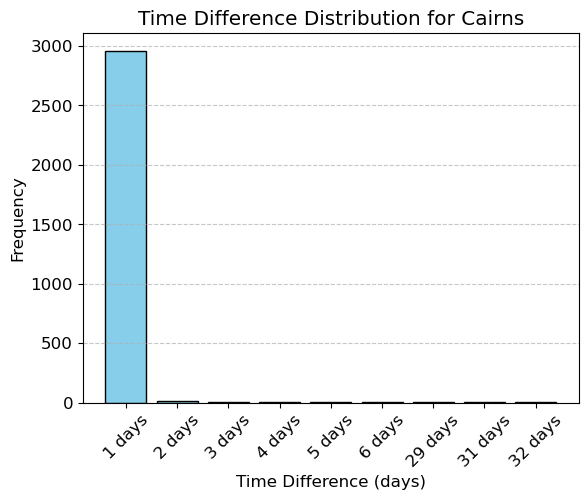

Time spacing counts for GoldCoast:
Date
1 days     2920
2 days       54
3 days        1
5 days        1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



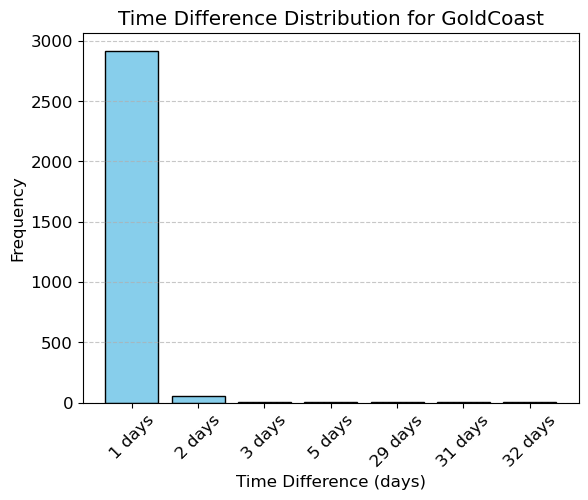

Time spacing counts for Townsville:
Date
1 days     3023
2 days        5
3 days        1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



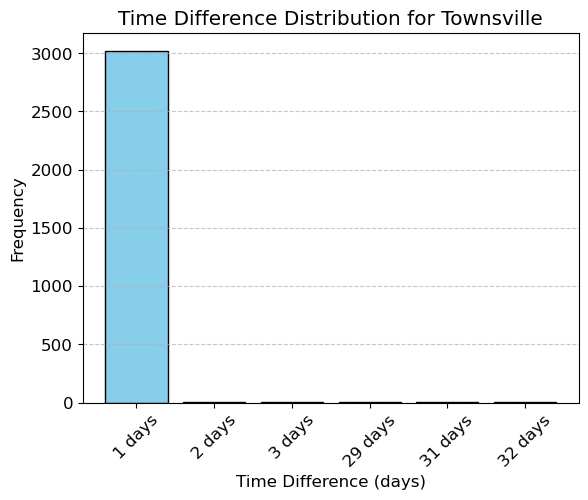

Time spacing counts for Adelaide:
Date
1 days     3016
2 days       42
3 days       24
4 days        4
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



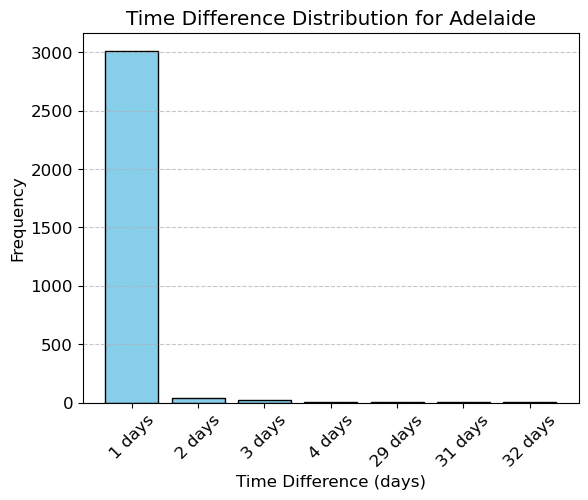

Time spacing counts for MountGambier:
Date
1 days     3018
2 days        7
3 days        1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



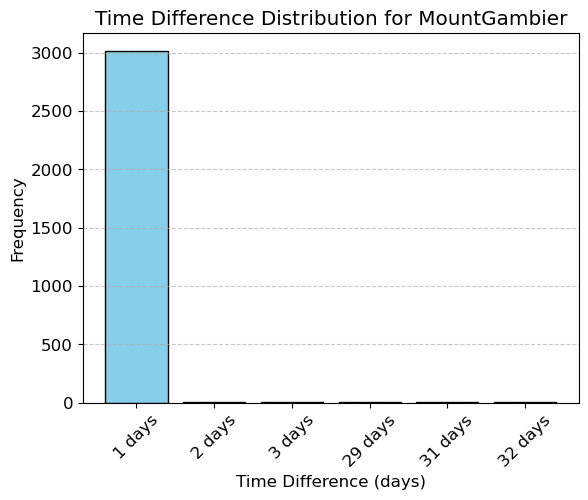

Time spacing counts for Nuriootpa:
Date
1 days     2992
2 days        6
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



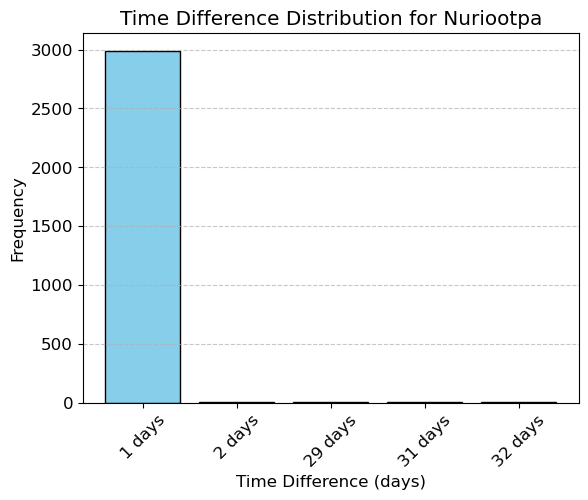

Time spacing counts for Woomera:
Date
1 days     2980
2 days        1
3 days        2
5 days        2
6 days        1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



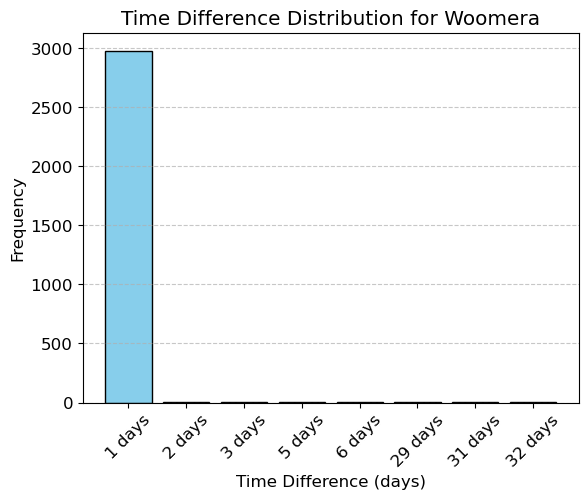

Time spacing counts for Albany:
Date
1 days     2993
2 days       15
3 days        4
29 days       1
31 days       1
33 days       1
Name: count, dtype: int64



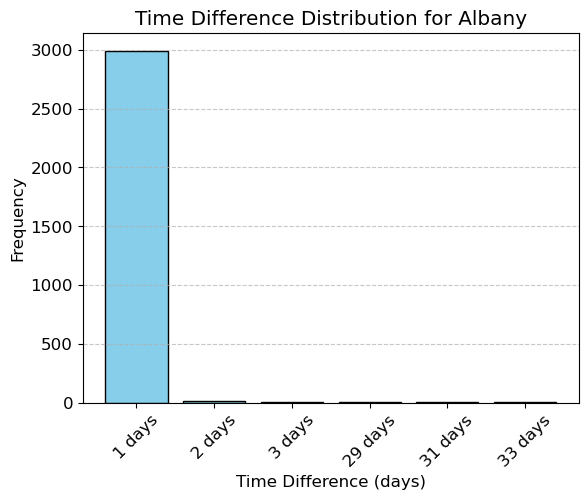

Time spacing counts for Witchcliffe:
Date
1 days     2920
2 days       17
3 days        4
4 days        2
5 days        2
6 days        1
7 days        1
8 days        1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



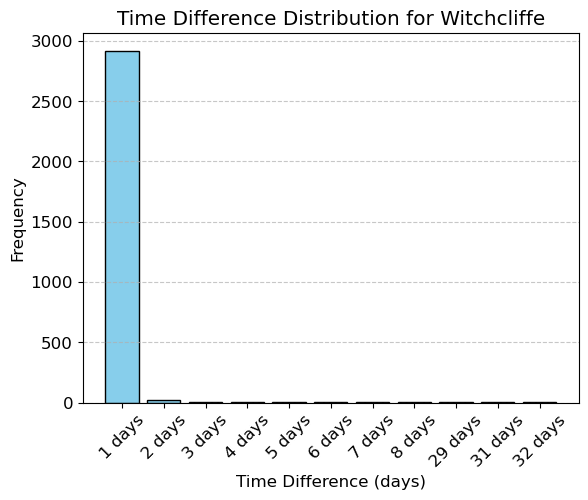

Time spacing counts for PearceRAAF:
Date
1 days     2642
2 days       16
3 days       92
4 days        5
5 days        1
9 days        1
21 days       1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



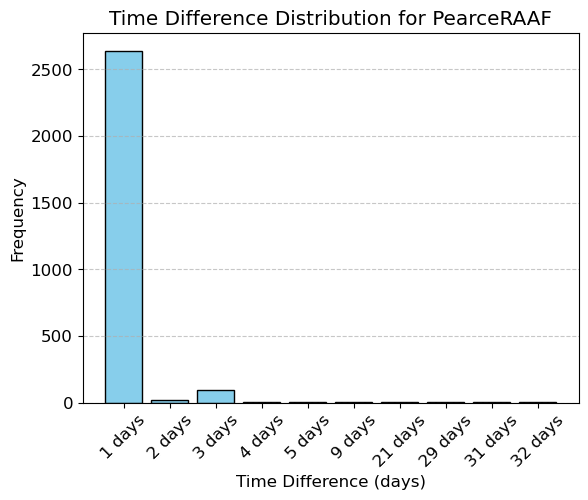

Time spacing counts for PerthAirport:
Date
1 days     3005
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



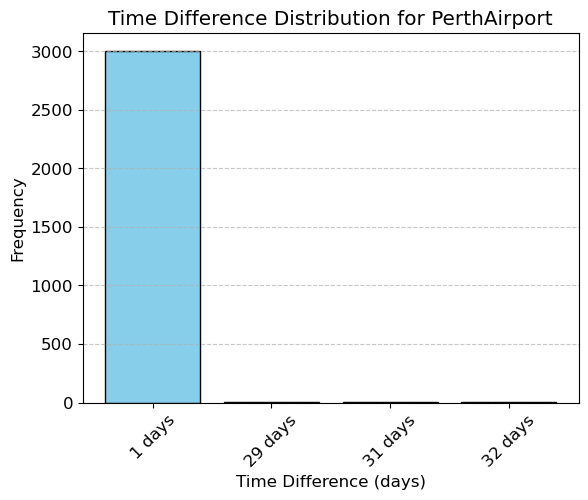

Time spacing counts for Perth:
Date
1 days     3189
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



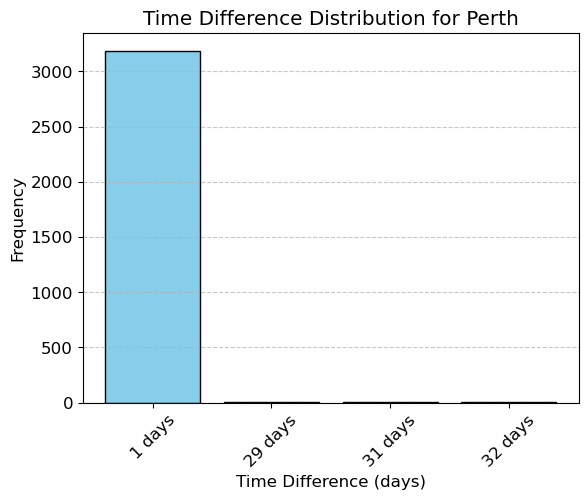

Time spacing counts for SalmonGums:
Date
1 days     2937
2 days        9
3 days        2
7 days        1
12 days       1
25 days       1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



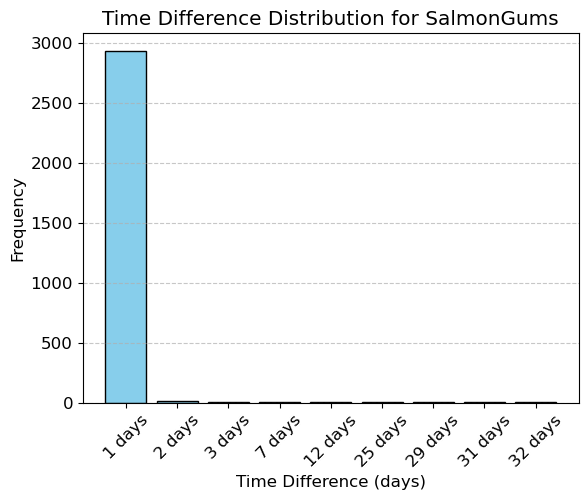

Time spacing counts for Walpole:
Date
1 days     2767
2 days       39
3 days        2
4 days        1
5 days        1
9 days        1
14 days       1
15 days       1
17 days       1
30 days       1
31 days       1
32 days       1
89 days       1
Name: count, dtype: int64



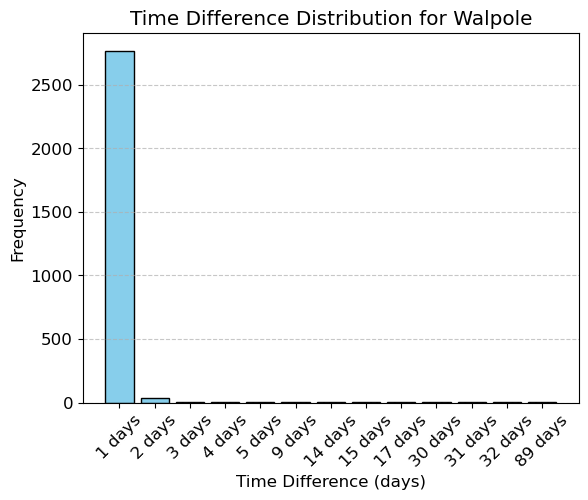

Time spacing counts for Hobart:
Date
1 days     3179
2 days        5
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



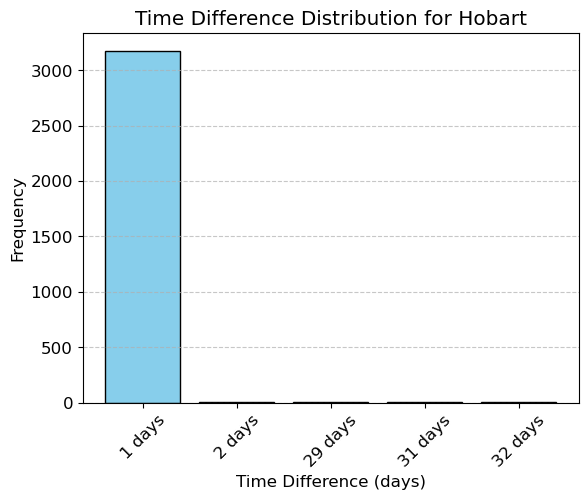

Time spacing counts for Launceston:
Date
1 days     3016
2 days        6
3 days        1
5 days        1
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



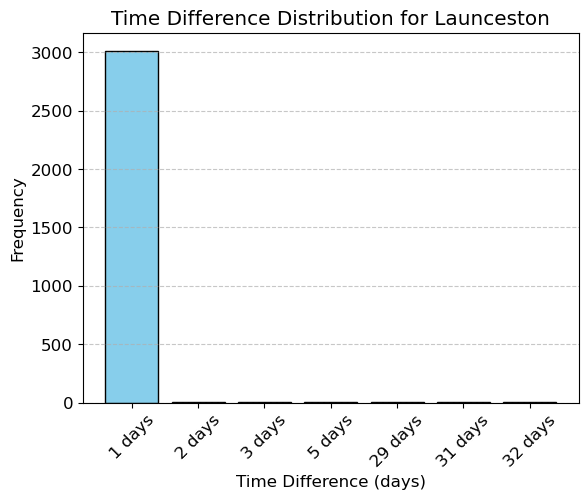

Time spacing counts for AliceSprings:
Date
1 days     3021
2 days        4
3 days        2
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



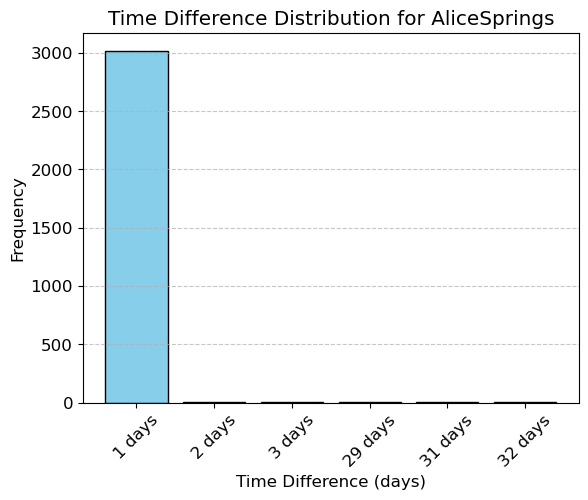

Time spacing counts for Darwin:
Date
1 days     3188
29 days       1
31 days       1
32 days       1
Name: count, dtype: int64



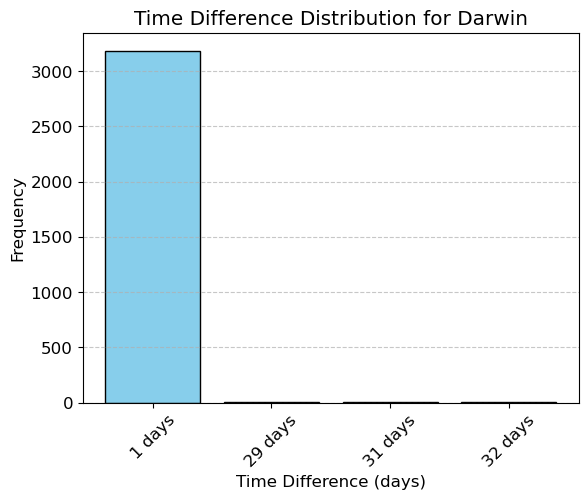

Time spacing counts for Katherine:
Date
1 days    1544
2 days      12
3 days       1
4 days       1
Name: count, dtype: int64



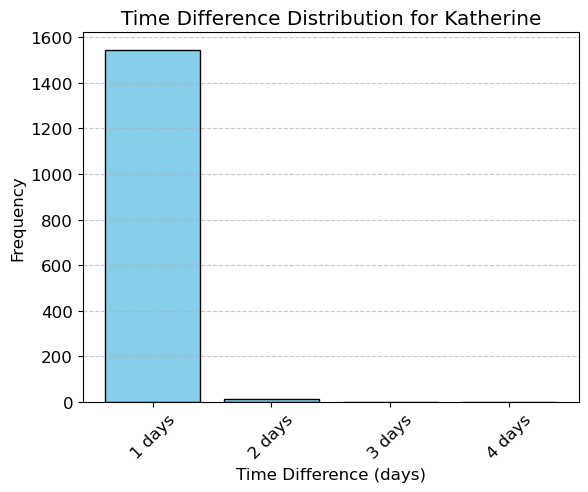

Time spacing counts for Uluru:
Date
1 days     1501
2 days       11
3 days        3
4 days        4
28 days       1
Name: count, dtype: int64



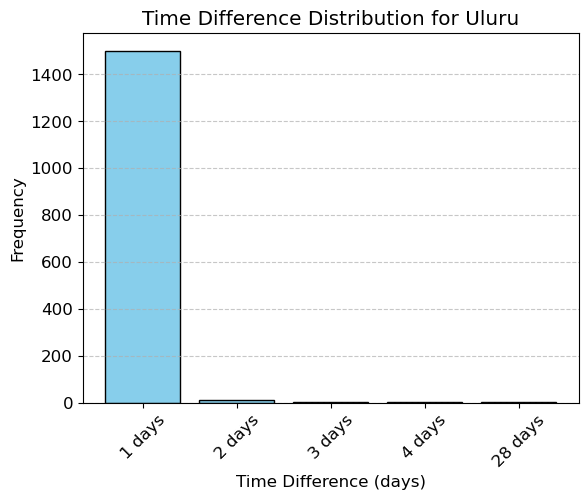

In [19]:
for loc in rain_df['Location'].unique():
    plot_time_spacing_distribution(rain_df, region=loc)

**Solution**
- There is one time series for each location.
- The measurements are usually one day apart for each region, but there are a few cases across different regions when measurements are 2-4 days apart, even up to 31 days apart at Melbourne Airport.

### <font color='red'>Question 2</font>

Create train/test splits, using at least 20% samples for the test set. Remember that we should not be calling the usual `train_test_split` with shuffling because if we want to forecast, we aren't allowed to know what happened in the future!

Make sure to call the resulting dataframes `train_df` and `test_df` for the rest of the notebook to work.

In [20]:
print(rain_df["Date"].min(), rain_df["Date"].max())
train_df = rain_df.query("Date <= 20150630")
test_df = rain_df.query("Date >  20150630")

2007-11-01 00:00:00 2017-06-25 00:00:00


### Preprocessing

We have different types of features requiring preprocessing. Let's define a preprocessor with a column transformer. 

This portion of the exercise is given to you, as it is not focused on using temporal information.

- We have missing data. 
- We have categorical features and numeric features. 
- To build a baseline, let's drop the date column and treat this as a usual supervised machine learning problem. 

In [21]:
numeric_features = [
    "MinTemp",
    "MaxTemp",
    "Rainfall",
    "Evaporation",
    "Sunshine",
    "WindGustSpeed",
    "WindSpeed9am",
    "WindSpeed3pm",
    "Humidity9am",
    "Humidity3pm",
    "Pressure9am",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "Temp9am",
    "Temp3pm",
]
categorical_features = [
    "Location",
    "WindGustDir",
    "WindDir9am",
    "WindDir3pm",
    "RainToday",
]
drop_features = ["Date"]
target = ["RainTomorrow"]

We'll be doing feature engineering and preprocessing features several times. So I've written a function for preprocessing. 

In [22]:
def preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features,
    target
):

    all_features = set(numeric_features + categorical_features + drop_features + target)
    if set(train_df.columns) != all_features:
        print("Missing columns", set(train_df.columns) - all_features)
        print("Extra columns", all_features - set(train_df.columns))
        raise Exception("Columns do not match")

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="median"), StandardScaler()
    )
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    )

    preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        ("drop", drop_features),
    )
    preprocessor.fit(train_df)
    ohe_feature_names = (
        preprocessor.named_transformers_["pipeline-2"]
        .named_steps["onehotencoder"]
        .get_feature_names_out(categorical_features)
        .tolist()
    )
    new_columns = numeric_features + ohe_feature_names

    X_train_enc = pd.DataFrame(
        preprocessor.transform(train_df), index=train_df.index, columns=new_columns
    )
    X_test_enc = pd.DataFrame(
        preprocessor.transform(test_df), index=test_df.index, columns=new_columns
    )

    y_train = train_df["RainTomorrow"]
    y_test = test_df["RainTomorrow"]

    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

In [23]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features, target
)

In [24]:
# Peek at X_train_enc to see the results of preprocessing
X_train_enc.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_missing,RainToday_No,RainToday_Yes,RainToday_missing
0,0.204302,-0.027112,-0.205323,-0.140641,0.160729,0.298612,0.666166,0.599894,0.115428,-1.433514,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,-0.741037,0.287031,-0.275008,-0.140641,0.160729,0.298612,-1.125617,0.373275,-1.314929,-1.288002,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.125523,0.372706,-0.275008,-0.140641,0.160729,0.450132,0.554180,0.826513,-1.632786,-1.045481,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,-0.457435,0.701128,-0.275008,-0.140641,0.160729,-1.216596,-0.341712,-1.099749,-1.261953,-1.724539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.850283,1.315134,-0.158867,-0.140641,0.160729,0.071330,-0.789657,0.146656,0.698167,-0.899969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### <font color='red'>Question 3</font>

Let's treat this as a usual supervised machine learning problem and create a couple of baseline models, to get an idea of what the performance would be if we ignored the time feature.

- Fit and score a `DummyClassifier` (for this exercise, score also on the test set)
- Fit and score a `LogisticRegression` model. 
- Comment on the performance of these baselines.
- Examine the coefficients of the logistic regression model. What features have the biggest impact on the output?

In [25]:
dc = DummyClassifier(strategy="most_frequent")
dc.fit(X_train_enc, y_train)

print("Training score:", dc.score(X_train_enc, y_train))
print("Testing score:", dc.score(X_test_enc, y_test))

Training score: 0.7750553478074826
Testing score: 0.7781845435415525


In [26]:
def score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc):
    lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
    lr_pipe.fit(train_df, y_train)
    print("Train score: {:.2f}".format(lr_pipe.score(train_df, y_train)))
    print("Test score: {:.2f}".format(lr_pipe.score(test_df, y_test)))
    lr_coef = pd.DataFrame(
        data=lr_pipe.named_steps["logisticregression"].coef_.flatten(),
        index=X_train_enc.columns,
        columns=["Coef"],
    )
    return lr_coef.sort_values(by="Coef", ascending=False)

In [27]:
score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc)

Train score: 0.85
Test score: 0.84


,Coef
Humidity3pm,1.247119
Pressure9am,0.871094
WindGustSpeed,0.718524
Location_Witchcliffe,0.709893
RainToday_missing,0.651446
...,...
Location_Townsville,-0.738564
Location_Wollongong,-0.767819
Location_MountGinini,-0.975895
RainToday_No,-0.994764


### <font color='red'>Question 4</font>

- Use [`TimeSeriesSplit`](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split) to carry out cross-validation for a `LogisticRegression` model. 

Some notes before proceeding:
- Things are a bit more complicated here because this dataset has **multiple time series**, one per location. 
- Our approach today will be to ignore the fact that we have multiple time series and just OHE the location
- We'll have multiple measurements for a given timestamp, and that's OK.
- But, `TimeSeriesSplit` expects the dataframe to be sorted by date so let's sort it by date before trying cross-validation.

In [28]:
train_df_ordered = train_df.sort_values(by=["Date"])
y_train_ordered = train_df_ordered["RainTomorrow"]

In [29]:
train_df_ordered

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
45587,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes
45588,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes
45589,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes
45590,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes
45591,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57415,2015-06-30,Ballarat,-0.3,10.5,0.0,NaN,NaN,S,26.0,NaN,...,99.0,63.0,1029.5,1027.7,NaN,8.0,4.7,9.3,No,No
119911,2015-06-30,PerthAirport,10.1,23.5,0.0,3.2,5.8,NNE,31.0,NE,...,48.0,33.0,1023.6,1021.7,7.0,6.0,13.3,22.2,No,No
60455,2015-06-30,Bendigo,0.3,11.4,0.0,NaN,NaN,W,19.0,NaN,...,89.0,56.0,1029.3,1027.4,8.0,7.0,6.4,10.5,No,No
66473,2015-06-30,MelbourneAirport,3.2,13.2,0.0,0.8,3.9,N,20.0,N,...,91.0,50.0,1029.6,1027.3,2.0,7.0,5.3,11.9,No,No


In [30]:
# Cross-validation
lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
cross_val_score(lr_pipe, train_df_ordered, y_train_ordered, cv=TimeSeriesSplit()).mean()

0.8478316682480326

### <font color='red'>Question 5</font>

The feature `Date` is probably very useful to predict the target (e.g. different amounts of rain in different seasons) - let's include it as feature!

This is feature engineering!

Think of at least 3 ways to generate features from the `Date` column. Some examples to start:
- Create a column for "days since starting date"
- Using the month as numerical feature, or One-hot encoding it
- One-hot encoding seasons (this requires converting months to seasons - also, remember that seasons are opposite in Australia!)

After adding the new features to the dataset, re-train a `LogisticRegression` model, and see how the performance has changed. Also, observe the coefficients: are the new features important?


In [31]:
# reset train_df, test_df
train_df = rain_df.query("Date <= 20150630")
test_df = rain_df.query("Date >  20150630")

In [32]:
def get_season(month):
    # remember this is Australia
    WINTER_MONTHS = ["June", "July", "August"] 
    AUTUMN_MONTHS = ["March", "April", "May"]
    SUMMER_MONTHS = ["December", "January", "February"]
    SPRING_MONTHS = ["September", "October", "November"]
    if month in WINTER_MONTHS:
        return "Winter"
    elif month in AUTUMN_MONTHS:
        return "Autumn"
    elif month in SUMMER_MONTHS:
        return "Summer"
    else:
        return "Spring"

In [33]:
first_day = train_df["Date"].min()

train_df = train_df.assign(
    Days_since=train_df["Date"].apply(lambda x: (x - first_day).days)
)
test_df = test_df.assign(
    Days_since=test_df["Date"].apply(lambda x: (x - first_day).days)
)


train_df = train_df.assign(
    Month=train_df["Date"].apply(lambda x: x.month_name())
)  # x.month_name() to get the actual string
test_df = test_df.assign(Month=test_df["Date"].apply(lambda x: x.month_name()))

train_df = train_df.assign(Season=train_df["Month"].apply(get_season))
test_df = test_df.assign(Season=test_df["Month"].apply(get_season))

train_df.sort_values(by="Date").head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Days_since,Month,Season
45587,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,1015.0,7.0,7.0,14.4,23.6,No,Yes,0,November,Spring
45588,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,1008.4,5.0,3.0,17.5,25.7,Yes,Yes,1,November,Spring
45589,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,1007.2,8.0,7.0,15.4,20.2,Yes,Yes,2,November,Spring
45590,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,1007.0,2.0,7.0,13.5,14.1,Yes,Yes,3,November,Spring
45591,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,1018.5,7.0,7.0,11.1,15.4,Yes,No,4,November,Spring


In [34]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features + ["Days_since"],
    categorical_features + ["Month", "Season"],
    drop_features,
    target
)

X_train_enc

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
0,0.204302,-0.027112,-0.205323,-0.140641,0.160729,0.298612,0.666166,0.599894,0.115428,-1.433514,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.741037,0.287031,-0.275008,-0.140641,0.160729,0.298612,-1.125617,0.373275,-1.314929,-1.288002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.125523,0.372706,-0.275008,-0.140641,0.160729,0.450132,0.554180,0.826513,-1.632786,-1.045481,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.457435,0.701128,-0.275008,-0.140641,0.160729,-1.216596,-0.341712,-1.099749,-1.261953,-1.724539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.850283,1.315134,-0.158867,-0.140641,0.160729,0.071330,-0.789657,0.146656,0.698167,-0.899969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144729,-1.308240,-0.683955,-0.275008,-0.140641,0.160729,-0.080190,0.554180,0.146656,0.221381,-0.705952,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
144730,-1.513063,-0.855306,-0.275008,-0.140641,0.160729,0.071330,0.330207,-0.419892,0.009476,-0.560439,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
144731,-1.197951,-0.498325,-0.275008,-0.140641,0.160729,-0.383232,0.106234,-1.326368,0.009476,-0.608943,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
144732,-0.709526,-0.155625,-0.275008,-0.140641,0.160729,-0.534753,0.666166,-0.419892,-0.096476,-0.705952,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [35]:
coeff_df = score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc)
coeff_df

Train score: 0.85
Test score: 0.84


,Coef
Humidity3pm,1.268339
Pressure9am,0.803373
Location_Witchcliffe,0.730512
WindGustSpeed,0.706533
RainToday_missing,0.704240
...,...
Location_Wollongong,-0.762965
Location_Townsville,-0.902122
Location_Katherine,-0.907874
RainToday_No,-0.944733


In [36]:
coeff_df.loc[["Season_Spring", "Season_Summer", "Season_Winter", "Season_Autumn"]]

,Coef
Season_Spring,-0.123826
Season_Summer,-0.369142
Season_Winter,-0.060019
Season_Autumn,-0.140986


### Lag-based features

Realistically, it may be helpful to know if it rained yesterday to predict if it will rain today. Let's add lagged features to our data.

We can "lag" (or "shift") a time series in Pandas with the .shift() method. 

In [37]:
# Recreating training and test set, to start from a clean slate

train_df = rain_df.query("Date <= 20150630")
test_df = rain_df.query("Date >  20150630")

In [38]:
# Adding 1 lagged column
train_df = train_df.assign(Rainfall_lag1=train_df["Rainfall"].shift(1))

In [39]:
train_df[["Date", "Location", "Rainfall", "Rainfall_lag1"]][:20]

,Date,Location,Rainfall,Rainfall_lag1
0,2008-12-01,Albury,0.6,NaN
1,2008-12-02,Albury,0.0,0.6
2,2008-12-03,Albury,0.0,0.0
3,2008-12-04,Albury,0.0,0.0
4,2008-12-05,Albury,1.0,0.0
5,2008-12-06,Albury,0.2,1.0
6,2008-12-07,Albury,0.0,0.2
7,2008-12-08,Albury,0.0,0.0
8,2008-12-09,Albury,0.0,0.0
9,2008-12-10,Albury,1.4,0.0


**Problem!** We have multiple time series here and we need to be more careful with this. 

When we switch from one location to another we do not want to take the value from the previous location. The function below will help with this task.

In [40]:
def create_lag_feature(
    df: pd.DataFrame,
    orig_feature: str,
    lag: int,
    groupby: list[str],
    new_feature_name: str | None = None,
    clip: bool = False,
) -> pd.DataFrame:
    """
    Create a lagged (or ahead) version of a feature, optionally per group.

    Assumes df is already sorted by time within each group and has unique indices.

    Parameters
    ----------
    df : pd.DataFrame
        The dataset.
    orig_feature : str
        Name of the column to lag.
    lag : int
        The lag:
          - negative → values from the past (t-1, t-2, ...)
          - positive → values from the future (t+1, t+2, ...)
    groupby : list of str
        Column(s) to group by if df contains multiple time series.
    new_feature_name : str, optional
        Name of the new column. If None, a name is generated automatically.
    clip : bool, default False
        If True, drop rows where the new feature is NaN.

    Returns
    -------
    pd.DataFrame
        A new dataframe with the additional column added.
    """
    if lag == 0:
        raise ValueError("lag cannot be 0 (no shift). Use the original feature instead.")

    # Default name if not provided
    if new_feature_name is None:
        if lag < 0:
            new_feature_name = f"{orig_feature}_lag{abs(lag)}"
        else:
            new_feature_name = f"{orig_feature}_ahead{lag}"

    df = df.copy()

    # Map your convention (negative=past, positive=future) to pandas shift
    # pandas: shift(+k) → past, shift(-k) → future
    periods = abs(lag) if lag < 0 else -lag

    df[new_feature_name] = (
        df.groupby(groupby, sort=False)[orig_feature]
          .shift(periods)
    )

    if clip:
        df = df.dropna(subset=[new_feature_name])

    return df


### <font color='red'>Question 6</font>

- Use `create_lag_feature` to add lagged rainfall features (1 day is enough to start).
- Discuss: would it be ok to add this feature to the test set? If the answer is yes, add it to the test set too.
- Fit and score a `LogisticRegression` model on this new dataset. Compare the results to what was achieved before.
- Observe the coefficients for `Rainfall` and `Rainfall_lag1`. What is their relationship with the target?

In [41]:
rain_df_modified = create_lag_feature(rain_df, "Rainfall", -1, groupby=["Location"])
train_df = rain_df_modified.query("Date <= 20150630")
test_df = rain_df_modified.query("Date >  20150630")
rain_df_modified

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Rainfall_lag1
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,NaN
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.6
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,0.0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,...,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,No,0.0
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No,0.0
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No,0.0
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No,0.0


In [42]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features + ["Rainfall_lag1"],
    categorical_features,
    drop_features,
    target
)

lr_coef = score_lr_print_coeff(
    preprocessor, train_df, y_train, test_df, y_test, X_train_enc
)

Train score: 0.85
Test score: 0.84


In [43]:
lr_coef.loc[["Rainfall", "Rainfall_lag1"]]

,Coef
Rainfall,0.081292
Rainfall_lag1,0.008040


Last, here are some more options for lagged features to check out:

- We could also create a lagged version of the target. In fact, this dataset already has that built in! `RainToday` is the lagged version of the target `RainTomorrow`.
- We could also create lagged version of other features, or more lags

In [44]:
rain_df_modified = create_lag_feature(rain_df, "Rainfall", -1, groupby=["Location"])
rain_df_modified = create_lag_feature(rain_df_modified, "Rainfall", -2, groupby=["Location"])
rain_df_modified = create_lag_feature(rain_df_modified, "Rainfall", -3, groupby=["Location"])
rain_df_modified = create_lag_feature(rain_df_modified, "Humidity3pm", -1, groupby=["Location"])

In [45]:
rain_df_modified[
    [
        "Date",
        "Location",
        "Rainfall",
        "Rainfall_lag1",
        "Rainfall_lag2",
        "Rainfall_lag3",
        "Humidity3pm",
        "Humidity3pm_lag1",
    ]
].head(10)

,Date,Location,Rainfall,Rainfall_lag1,Rainfall_lag2,Rainfall_lag3,Humidity3pm,Humidity3pm_lag1
0,2008-12-01,Albury,0.6,NaN,NaN,NaN,22.0,NaN
1,2008-12-02,Albury,0.0,0.6,NaN,NaN,25.0,22.0
2,2008-12-03,Albury,0.0,0.0,0.6,NaN,30.0,25.0
3,2008-12-04,Albury,0.0,0.0,0.0,0.6,16.0,30.0
4,2008-12-05,Albury,1.0,0.0,0.0,0.0,33.0,16.0
5,2008-12-06,Albury,0.2,1.0,0.0,0.0,23.0,33.0
6,2008-12-07,Albury,0.0,0.2,1.0,0.0,19.0,23.0
7,2008-12-08,Albury,0.0,0.0,0.2,1.0,19.0,19.0
8,2008-12-09,Albury,0.0,0.0,0.0,0.2,9.0,19.0
9,2008-12-10,Albury,1.4,0.0,0.0,0.0,27.0,9.0


Note the pattern of `NaN` values. 

In [46]:
train_df = rain_df_modified.query("Date <= 20150630")
test_df = rain_df_modified.query("Date >  20150630")

In [47]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features
    + ["Rainfall_lag1", "Rainfall_lag2", "Rainfall_lag3", "Humidity3pm_lag1"],
    categorical_features,
    drop_features,
    target
)

In [48]:
lr_coef = score_lr_print_coeff(
    preprocessor, train_df, y_train, test_df, y_test, X_train_enc
)

Train score: 0.85
Test score: 0.85


In [49]:
lr_coef.loc[
    [
        "Rainfall",
        "Rainfall_lag1",
        "Rainfall_lag2",
        "Rainfall_lag3",
        "Humidity3pm",
        "Humidity3pm_lag1",
    ]
]

,Coef
Rainfall,0.107917
Rainfall_lag1,0.023105
Rainfall_lag2,0.018434
Rainfall_lag3,0.017829
Humidity3pm,1.278441
Humidity3pm_lag1,-0.266120


Note the pattern in the magnitude of the coefficients. 